In [1]:
 from __future__ import print_function

import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from bs4 import BeautifulSoup
import numpy as np
import base64
import re
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [ ]:
# чтобы это запустилось, нужно сделать что написано здесь https://developers.google.com/gmail/api/quickstart/python
# часть кода взята отсюда https://www.geeksforgeeks.org/how-to-read-emails-from-gmail-using-gmail-api-in-python/

SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

creds = None
if os.path.exists('token_slava.json'):
    creds = Credentials.from_authorized_user_file('token_slava.json', SCOPES)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials_slava.json', SCOPES)
        creds = flow.run_local_server(port=0)
    with open('token_slava.json', 'w') as token:
        token.write(creds.to_json())

service = build('gmail', 'v1', credentials=creds)
  
result = service.users().messages().list(userId='me', maxResults=100).execute()

messages = result.get('messages')

In [ ]:
sources = ['Открытие', 'Movchan', 'АТОN RESEARCH', 'Bloomberg', 'ROSBANK Research']

for n in tqdm(range(28)):
    if n != 0:
        page_token = result['nextPageToken']
        result = service.users().messages().list(userId='me', pageToken=page_token).execute()
        messages = result.get('messages')
    for msg in messages:
        txt = service.users().messages().get(userId='me', id=msg['id']).execute()
        payload = txt['payload']
        headers = payload['headers']

        for d in headers:
            if d['name'] == 'Subject':
                subject = d['value']
            if d['name'] == 'From':
                sender = d['value']
            if d['name'] == 'Date':
                date = d['value']
        if any([source in sender for source in sources]):
            try:
                parts = payload.get('parts')[0]
            except:
                pass
            try:
                data = parts['body']['data']
            except:
                data = parts.get('parts')[0]['body']['data']

            data = data.replace("-","+").replace("_","/")
            decoded_data = base64.b64decode(data)
            soup = BeautifulSoup(decoded_data , "lxml")
            body = soup.body()

            if 'Открытие' in subject:
                lines = re.sub('\s+', ' ', soup.get_text(strip=True))
                lines = lines[lines.find('Главное'):lines.find('Читать')]
            elif 'ROSBANK Research' in sender:
                lines = re.sub('\s+', ' ', soup.get_text(strip=True))
                lines = lines[:lines.find('Напишите нам')]
            elif 'Bloomberg' in sender:
                lines = re.sub('\s+', ' ', soup.get_text(strip=True))
                lines = lines[:lines.find('You received this message')]
            elif 'АТОN RESEARCH' in sender:
                lines = re.sub('\s+', ' ', soup.get_text(strip=True))
                lines = lines[lines.find('Рынок акций'):lines.find('Все права защищены')]
            elif 'Movchan' in sender:
                lines = re.sub('\s+', ' ', soup.get_text(strip=True))
                lines = lines[:lines.find('Подписаться на рассылку')]
            words = [date, lines]
            with open('записки.txt', 'a') as f:
                for line in words:
                    try:
                        f.write(line)
                        f.write('\n')
                    except:
                        pass
                f.write('\n')

# EDA

In [2]:
with open('аналитические записки.txt') as f:
    lines = f.readlines()
data = [i.strip() for i in lines]
mask_data = [len(i)!=0 for i in data]
data = np.array(data)[mask_data]
len_data = np.array([len(i) for i in data])
mask = np.array([len_data[i] < 50 and len_data[i+1] < 50 for i in range(len(data))])
data1 = data[~mask]

In [3]:
data2 = []
for i in data1[::2]:
    data2.append(re.findall('\d\s[A-Z][a-z]+\s\d{4}', i))
data2 = np.array(data2).flatten()
data2 = np.array([i[0].zfill(2) + i[1:] for i in data2])
data2 = pd.to_datetime(data2, format='%d %b %Y', errors='coerce')

In [4]:
d = {'Date': pd.DataFrame(data2).fillna(method='ffill').values.flatten(), 'data': data1[1::2]} 
df = pd.DataFrame(d)

In [5]:
vse = ''.join(data1[1::2]).lower()

In [6]:
words = '''повыш
рост
увелич
подъем
позитив 
улучш
доход
инфляц
пад
сниж
ухудш
рецесс
кризис
замедл
ускор
негатив
восстан
ставк
риск
объем
торг
тренд
сбере
адаптац
неопределен
аппетит
рын
настроени
нефт
инвестиц
фьючерс
индекс
ликвидн
валюта
акции
офз
облиг
евробонд
руб
доллар
ЦБ
регулятор
ввп
стоимо
цен
период
прогноз
показатель
курс
оценк
минфин
inflation
index
market
markets
data
bank
yield
treasury
rate 
invest
futures
stock
stoxx
policy
analysis
companies
price
bond
gain
grow
financial
reserve
demand 
supply
risk 
money
auction
powell
overnight
stimulus
report
interest
monetary
real
government
meeting
ris
debt
drop
nasdaq
share
hike
spending
equity
fiscal
primary'''

In [7]:
words = np.array(words.split('\n'))
words = np.array([i.strip() for i in words])

In [8]:
d = {}
keys = pd.Series(' '.join(df['data']).lower().split()).value_counts().keys()
for j in tqdm(words):
    similar = keys[np.array([j in i for i in keys])]
    qty = pd.Series(' '.join(df['data']).lower().split()).value_counts().loc[similar].values.sum()
    d[j] = qty

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:37<00:00,  2.61it/s]


In [9]:
d = {}
qty_all = pd.Series(' '.join(df['data']).lower().split()).value_counts()
keys = qty_all.keys()
for j in tqdm(words):
    similar = set(re.findall(fr'\b{j}\w*', vse))
    qty = qty_all.reindex(similar).sum()
    d[j] = qty

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:09<00:00, 10.36it/s]


In [10]:
pd.Series(d).sort_values(ascending=False)

market       2244.0
рын          1972.0
inflation    1618.0
ставк        1608.0
прогноз      1531.0
              ...  
адаптац        28.0
рецесс         19.0
евробонд        0.0
подъем          0.0
ЦБ              0.0
Length: 97, dtype: float64

In [11]:
all_text = []
zeros = []
for i in tqdm(words):
    text = re.findall(fr'\b{i}\w*', vse)
    text = ' '.join([i for j in range(len(text))])
    all_text.append(text)

all_text = ' '.join(all_text)

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:09<00:00, 10.45it/s]


In [12]:
# Import package
import matplotlib.pyplot as plt
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

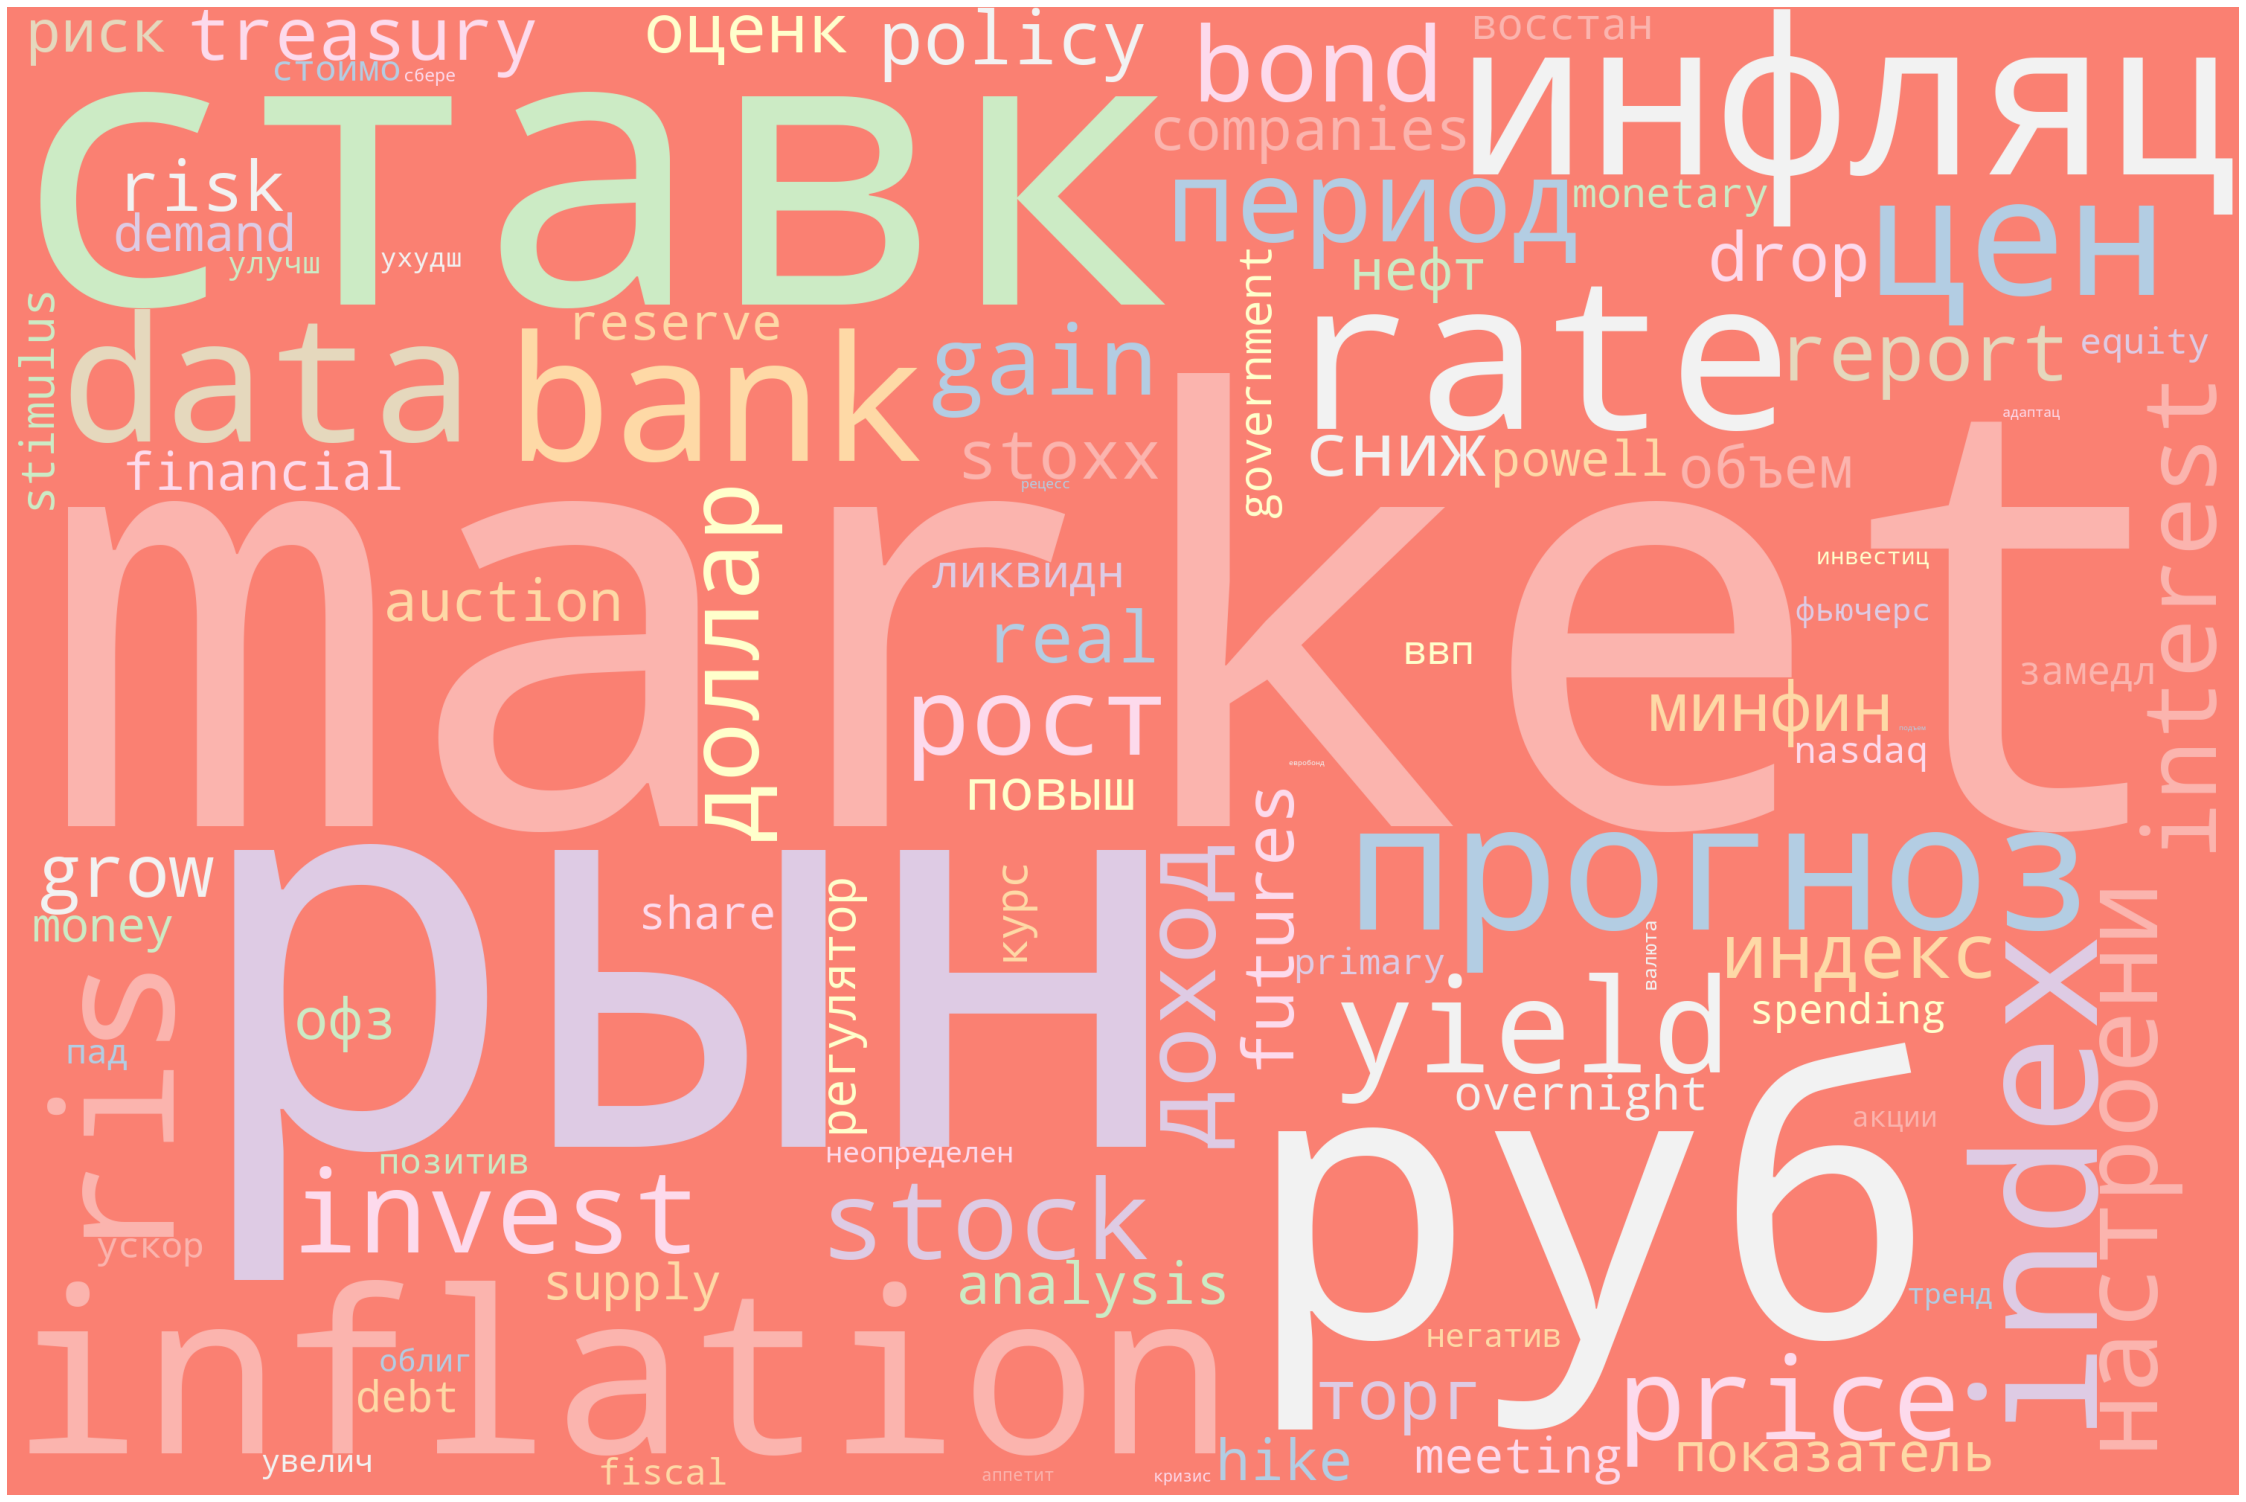

In [13]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(all_text)
# Plot
plot_cloud(wordcloud)